In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
from tqdm import tqdm

## tensorflow version
import tensorflow as tf
from tensorflow.keras import *

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image


import tensorflow.keras.backend as K, gc


import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None
LOAD_SEGMENTATION_FROM = '/kaggle/input/cxr-unet/'


tensorflow version:  2.16.1
Using 2 GPUs


In [2]:
df = pd.read_csv('/kaggle/input/rapid-cxr-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*', '*'))}    
    
df['path'] = df['Image Index'].map(tmp)

In [3]:
!pip install -q -U segmentation_models

In [4]:
os.environ["SM_FRAMEWORK"] = 'tf.keras'
import segmentation_models

Segmentation Models: using `tf.keras` framework.


In [5]:
from segmentation_models import Unet
preprocess = segmentation_models.get_preprocessing('resnet18')

def build_unet():
    
    unet_model = Unet('resnet18', input_shape=(512,512,3), classes=1, activation='sigmoid')
    
    ## Freezing Layers(10%)
    for layer in unet_model.layers[:len(unet_model.layers)//10]:
        layer.trainable=False

    dice_loss = segmentation_models.losses.DiceLoss()
    dice_metric = segmentation_models.metrics.FScore(threshold=0.5)

    opt = optimizers.Adam(learning_rate=1e-4)
    
    unet_model.compile(optimizer=opt, loss=dice_loss, metrics=[dice_metric])
    
    return unet_model

In [6]:
import albumentations as albu

class MaskGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, preprocess=None):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocess = preprocess
        self.on_epoch_end()
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        
    def __len__(self):
        # Drop_Last = False
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
    
    def __data_generation(self, indexes):    
        X = np.zeros((len(indexes),512,512,3), dtype='float32')
        
        for j,i in enumerate(indexes):
            ## Image
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((512,512), Image.Resampling.LANCZOS) # DownSampling
            img = np.array(img) # PIL Object -> np.array(uint8)
            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
            
            X[j,] = img
            if self.preprocess != None: X = self.preprocess(X)
                
                
        return X

In [7]:
gen = MaskGenerator(df, batch_size=32, shuffle=False, preprocess=preprocess)

K.clear_session()
with strategy.scope(): unet = build_unet()
    
unet.load_weights(f'{LOAD_SEGMENTATION_FROM}UNet_f0.weights.h5')
    
all_mask = unet.predict(gen, verbose=1)

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step


In [8]:
all_mask = np.where(all_mask >= 0.5, 1, 0)
all_mask = (all_mask * 255).astype('uint8').squeeze()

#all_mask = cv2.dilate(all_mask, None, iterations=2)
#all_mask = cv2.erode(all_mask, None, iterations=1)

In [9]:
def crop_imgs(path, mask):
    
    ### First Step: Get the original Image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    img = Image.open(path).convert('L')
    img = img.resize((512,512), Image.Resampling.LANCZOS) # DownSampling
    img = np.array(img) # PIL Object -> np.array(uint8)
    img = clahe.apply(img)
    img = np.expand_dims(img, axis=-1)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
    
    ### Second Step: Find First, Second Biggest Contours
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    ### Thrid Step: Find the Extreme Points
    if len(cnts) == 1:
        c0 = cnts[0]
        combined_contour = c0
        img_cnt = cv2.drawContours(img.copy(), [c0], -1, (0,255,255), 5)
        
        extLeft = tuple(combined_contour[combined_contour[:,:,0].argmin()][0])  # x좌표 최소
        extRight = tuple(combined_contour[combined_contour[:,:,0].argmax()][0])  # x좌표 최대
        extTop = tuple(combined_contour[combined_contour[:,:,1].argmin()][0])  # y좌표 최소
        extBot = tuple(combined_contour[combined_contour[:,:,1].argmax()][0])  # y좌표 최대
    
        new_img = img[extTop[1]:extBot[1],
                 extLeft[0]:extRight[0]].copy()
    elif len(cnts) >= 2:
        c0 = cnts[0]
        c1 = cnts[1]
        combined_contour = np.vstack((c0, c1))
        img_cnt = cv2.drawContours(img.copy(), [c0], -1, (0,255,255), 5)
        img_cnt = cv2.drawContours(img_cnt, [c1], -1, (0,255,255), 5)

        extLeft = tuple(combined_contour[combined_contour[:,:,0].argmin()][0])  # x좌표 최소
        extRight = tuple(combined_contour[combined_contour[:,:,0].argmax()][0])  # x좌표 최대
        extTop = tuple(combined_contour[combined_contour[:,:,1].argmin()][0])  # y좌표 최소
        extBot = tuple(combined_contour[combined_contour[:,:,1].argmax()][0])  # y좌표 최대
    
        new_img = img[extTop[1]:extBot[1],
                 extLeft[0]:extRight[0]].copy()
    else:
        new_img = img


    return new_img

### Feature 1: Dullness

In [10]:
def color_analysis(img):
    
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
        
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse=True)
    
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]):
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]):
            light_shade += x[1]
        
        shade_count += x[1]
        
        light_percent = round((float(light_shade)/shade_count)*100,2)
        
        dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    
    return light_percent, dark_percent

In [11]:
def perform_color_analysis(path, flag):
    img = Image.open(path).convert('RGB')
    img = np.array(img)
    cropped_img = crop_imgs(path, all_mask[df[df['path'] == path].index[0]])
    cropped_img = cv2.resize(cropped_img, (512, 512), interpolation=cv2.INTER_LANCZOS4)
    img = Image.fromarray(cropped_img)
    
    size = img.size # Width, Height Channel 
    halves = (size[0]/2, size[1]/2)
    # left, upper, right, lower
    img1 = img.crop((0,0, size[0], halves[1]))
    img2 = img.crop((0,halves[1],size[0],size[1]))
    
    try:
        light_percent1, dark_percent1 = color_analysis(img1)
        light_percent2, dark_percent2 = color_analysis(img2)
    except Exception as e:
        return None
    
    light_percent = (light_percent1 + light_percent2) / 2
    dark_percent = (dark_percent1 + dark_percent2) / 2
    
    if flag == 'black':
        return dark_percent
    elif flag == 'white':
        return light_percent
    else: 
        return None

In [12]:
%%time
df['dullness'] = df['path'].apply(lambda x: perform_color_analysis(x, 'black'))

CPU times: user 7min 15s, sys: 32.2 s, total: 7min 47s
Wall time: 6min 18s


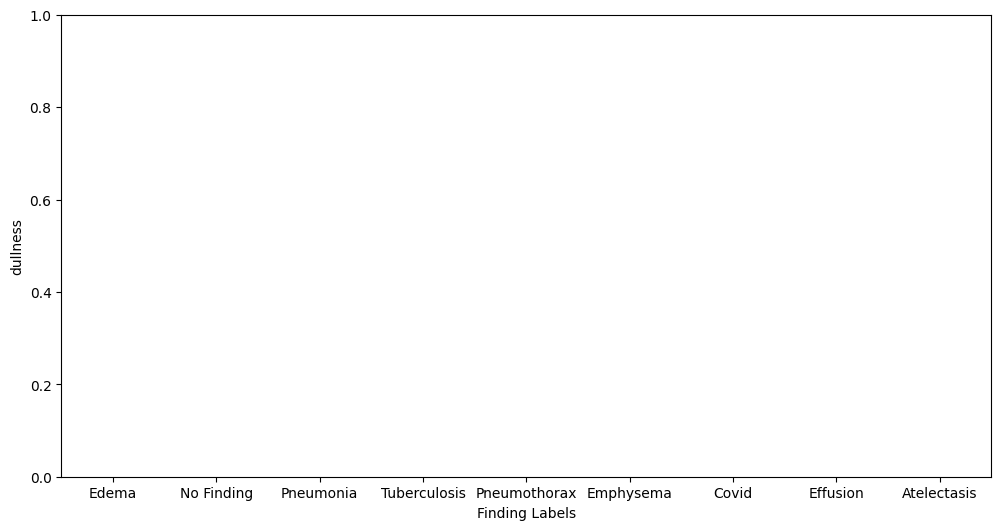

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Finding Labels'], y=df['dullness'])
plt.show()

### Feature 2: Whiteness

=> Image Whiteness Score

In [14]:
%%time
df['whiteness'] = df['path'].apply(lambda x: perform_color_analysis(x, 'white'))

CPU times: user 7min 12s, sys: 32.4 s, total: 7min 45s
Wall time: 6min 16s


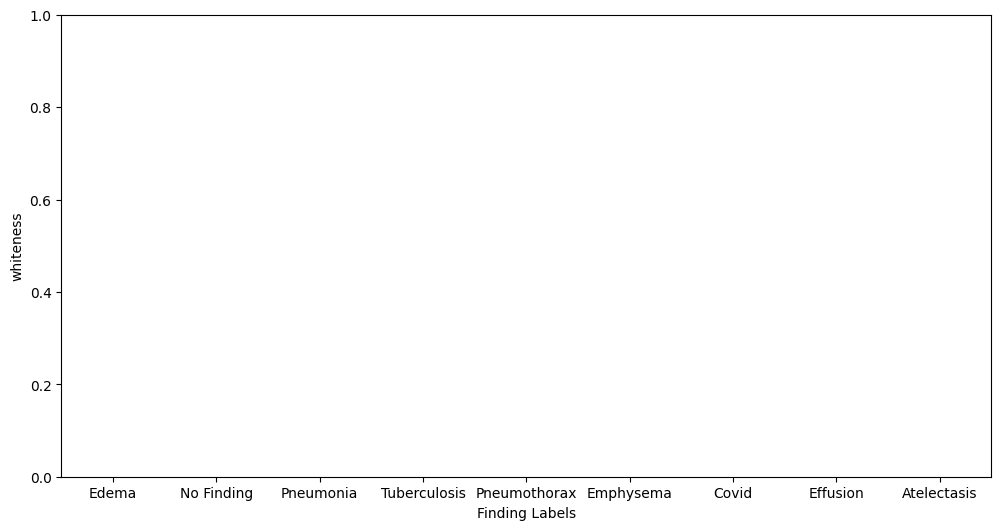

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Finding Labels'], y=df['whiteness'])
plt.show()

### Feature 3: Uniformity

=> Average Pixel Width

In [16]:
from skimage import feature

In [17]:
def average_pixel_width(path):
    cropped_img = crop_imgs(path, all_mask[df[df['path'] == path].index[0]])
    cropped_img = cv2.resize(cropped_img, (512, 512), interpolation=cv2.INTER_LANCZOS4)
    im = Image.fromarray(cropped_img)
    im_array = np.asarray(im.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

In [18]:
%%time
df['apw'] = df['path'].apply(lambda x: average_pixel_width(x))

CPU times: user 5min 29s, sys: 29 s, total: 5min 58s
Wall time: 4min 27s


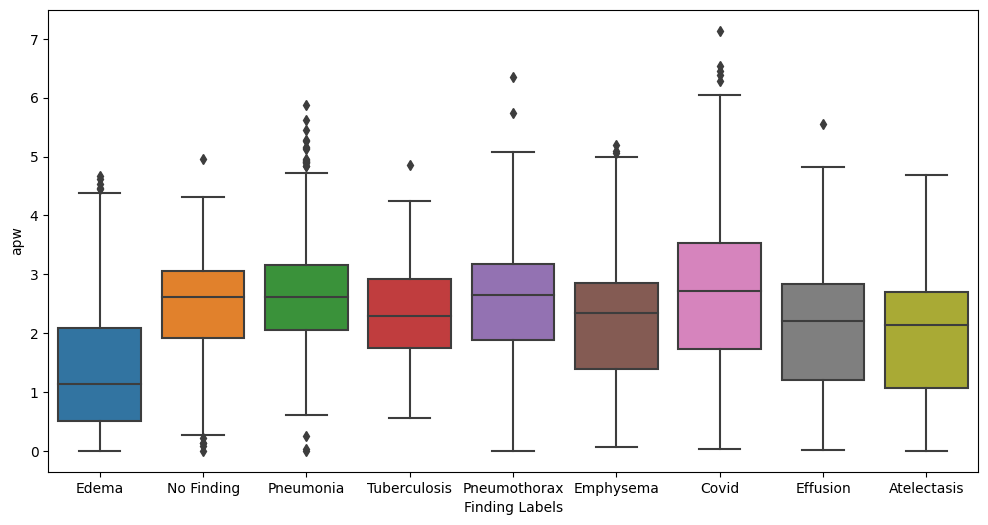

In [19]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Finding Labels'], y=df['apw'])
plt.show()

### Feature 4: Colors

=> Average Color of the Image 

In [20]:
def get_average_color(path):
    cropped_img = crop_imgs(path, all_mask[df[df['path'] == path].index[0]])
    cropped_img = cv2.resize(cropped_img, (512, 512), interpolation=cv2.INTER_LANCZOS4)
    img = cropped_img
    average_red = img[:,:,0].mean()
    average_green = img[:,:,1].mean()
    average_blue = img[:,:,2].mean()
    
    average = [average_red,  average_green,  average_blue]
    return average

In [21]:
%%time
df['average_red'] = df['path'].apply(lambda x: get_average_color(x)[0])
df['average_green'] = df['path'].apply(lambda x: get_average_color(x)[1])
df['average_blue'] = df['path'].apply(lambda x: get_average_color(x)[2])


CPU times: user 10min 3s, sys: 1min 25s, total: 11min 29s
Wall time: 6min 58s


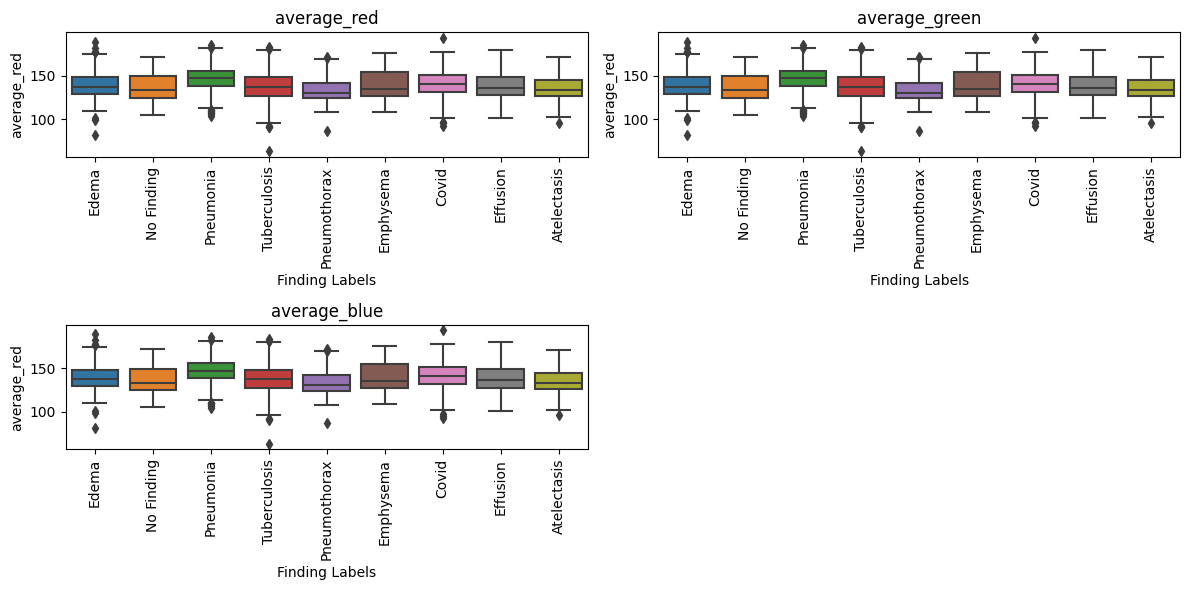

In [22]:
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.title('average_red')
sns.boxplot(x=df['Finding Labels'], y=df['average_red'])
plt.xticks(rotation=90)
plt.subplot(2,2,2)
plt.title('average_green')
sns.boxplot(x=df['Finding Labels'], y=df['average_red'])
plt.xticks(rotation=90)
plt.subplot(2,2,3)
plt.title('average_blue')
sns.boxplot(x=df['Finding Labels'], y=df['average_red'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Feature 5: Blurness

=> Width of th Image

In [23]:
def get_blurrness_score(path):
    cropped_img = crop_imgs(path, all_mask[df[df['path'] == path].index[0]])
    cropped_img = cv2.resize(cropped_img, (512, 512), interpolation=cv2.INTER_LANCZOS4)
    image = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm

In [24]:
%%time
df['average_color'] = df['path'].apply(lambda x: get_blurrness_score(x))

CPU times: user 3min 26s, sys: 29.8 s, total: 3min 56s
Wall time: 2min 23s


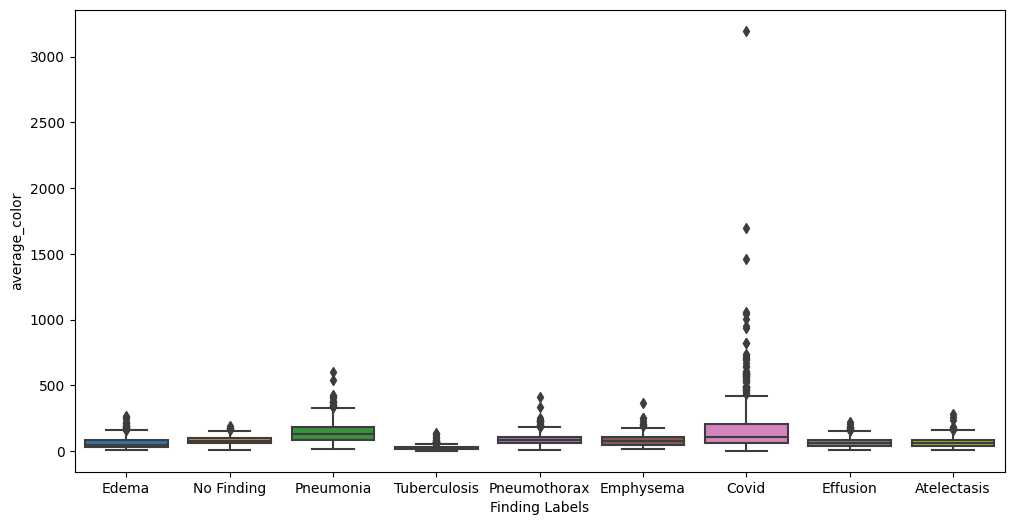

In [25]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Finding Labels'], y=df['average_color'])
plt.show()